In [3]:
from IPython.display import clear_output
!pip install imutils
clear_output()

In [4]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [5]:
!apt-get install tree
clear_output()
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d


mkdir: cannot create directory ‘TRAIN’: File exists
mkdir: cannot create directory ‘TEST’: File exists
mkdir: cannot create directory ‘VAL’: File exists
mkdir: cannot create directory ‘TRAIN/YES’: File exists
mkdir: cannot create directory ‘TRAIN/NO’: File exists
mkdir: cannot create directory ‘TEST/YES’: File exists
mkdir: cannot create directory ‘TEST/NO’: File exists
mkdir: cannot create directory ‘VAL/YES’: File exists
mkdir: cannot create directory ‘VAL/NO’: File exists
.
├── btd
│   ├── no
│   └── yes
├── preview
├── sample_data
├── TEST
│   ├── NO
│   └── YES
├── TEST_CROP
│   ├── NO
│   └── YES
├── TRAIN
│   ├── NO
│   └── YES
├── TRAIN_CROP
│   ├── NO
│   └── YES
├── VAL
│   ├── NO
│   └── YES
└── VAL_CROP
    ├── NO
    └── YES

23 directories


In [6]:
IMG_PATH = '/content/btd/'
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        print(CLASS)
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            print(FILE_NAME)
            if n < 5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

no
no 100.jpg
39 no.jpg
1 no.jpeg
32 no.jpg
5 no.jpg
43 no.jpg
no 92.jpg
22 no.jpg
no 8.jpg
6 no.jpg
no 91.jpeg
48 no.jpeg
23 no.jpg
no 7.jpeg
no 4.jpg
47 no.jpg
N20.jpg
N19.jpg
36 no.jpg
No22.jpg
No16.jpg
40 no.jpg
19 no.jpg
N1.jpg
15 no.jpg
N15.jpg
8 no.jpg
no 923.jpg
no 98.jpg
no 95.jpg
No21.jpg
no 10.jpg
21 no.jpg
3 no.jpg
no 90.jpg
31 no.jpg
28 no.jpg
34 no.jpg
49 no.jpg
N17.jpg
no 94.jpg
33 no.jpg
20 no.jpg
no.jpg
11 no.jpg
35 no.jpg
38 no.jpg
N22.jpg
2 no.jpeg
N21.jpg
4 no.jpg
N26.jpg
46 no.jpg
37 no.jpg
No13.jpg
No15.jpg
13 no.jpg
50 no.jpg
44no.jpg
no 96.jpg
17 no.jpg
no 9.png
no 6.jpg
26 no.jpg
24 no.jpg
N2.jpg
no 5.jpeg
41 no.jpg
14 no.jpg
N11.jpg
7 no.jpg
42 no.jpg
18 no.jpg
N5.jpg
No20.jpg
No18.jpg
no 3.jpg
N6.jpg
27 no.jpg
No11.jpg
No12.jpg
12 no.jpg
no 97.jpg
45 no.jpg
N3.jpg
no 1.jpg
29 no.jpg
no 2.jpg
no 89.jpg
No14.jpg
30 no.jpg
N16.jpg
10 no.jpg
No19.jpg
No17.jpg
9 no.jpg
no 99.jpg
25 no.jpg
yes
Y146.jpg
Y53.jpg
Y34.jpg
Y112.jpg
Y101.jpg
Y107.jpg
Y252.jpg
Y108.jpg
Y2

In [7]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [8]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)


100%|██████████| 2/2 [00:00<00:00,  3.27it/s]
<ipython-input-7-eef909fe42ff>:18: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



193 images loaded from TRAIN/ directory.


100%|██████████| 2/2 [00:00<00:00, 77.17it/s]


10 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:00<00:00, 11.90it/s]

50 images loaded from VAL/ directory.


In [15]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)


In [9]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()


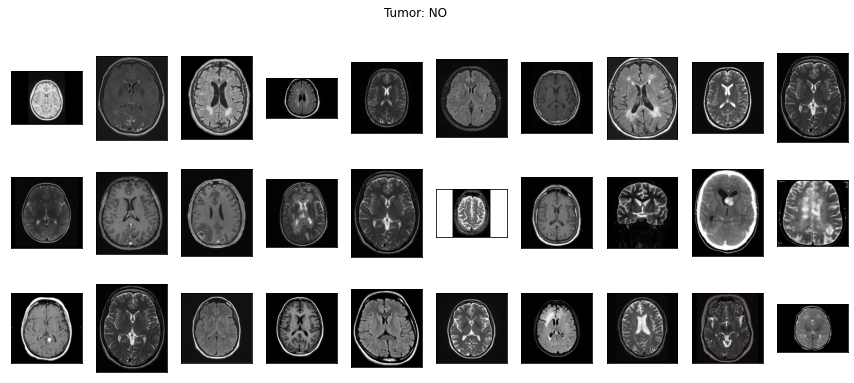

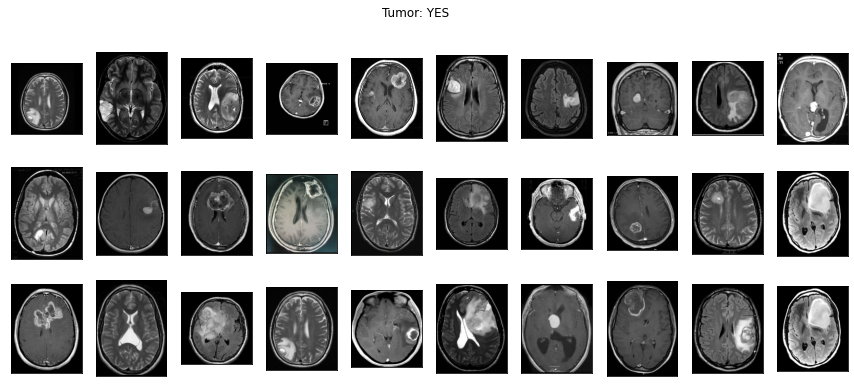

In [10]:
plot_samples(X_train, y_train, labels, 30)


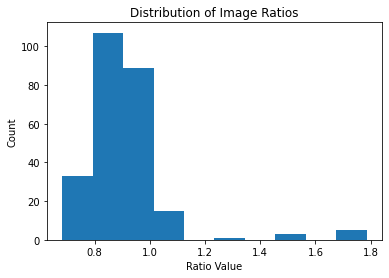

In [11]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

In [12]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)


In [13]:
img = cv2.imread('/content/btd/yes/Y108.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()



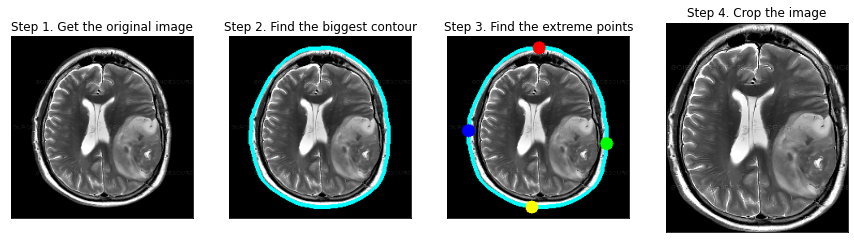

In [14]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()


In [15]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)


<ipython-input-12-65876982ba26>:31: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



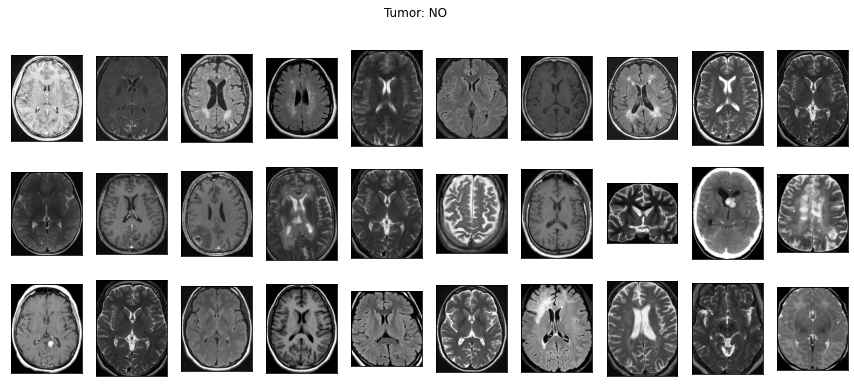

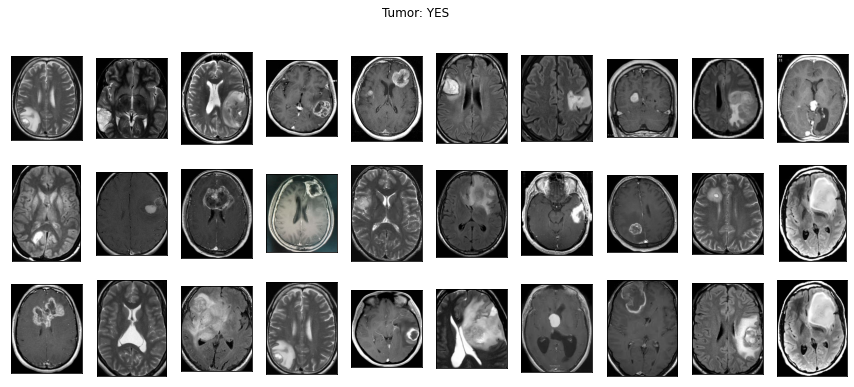

In [16]:
plot_samples(X_train_crop, y_train, labels, 30)

In [17]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [18]:
# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

mkdir: cannot create directory ‘TRAIN_CROP’: File exists
mkdir: cannot create directory ‘TEST_CROP’: File exists
mkdir: cannot create directory ‘VAL_CROP’: File exists
mkdir: cannot create directory ‘TRAIN_CROP/YES’: File exists
mkdir: cannot create directory ‘TRAIN_CROP/NO’: File exists
mkdir: cannot create directory ‘TEST_CROP/YES’: File exists
mkdir: cannot create directory ‘TEST_CROP/NO’: File exists
mkdir: cannot create directory ‘VAL_CROP/YES’: File exists
mkdir: cannot create directory ‘VAL_CROP/NO’: File exists


In [19]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [20]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)


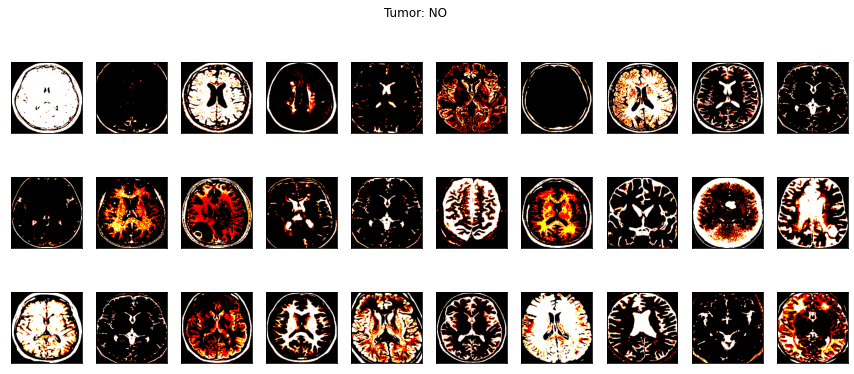

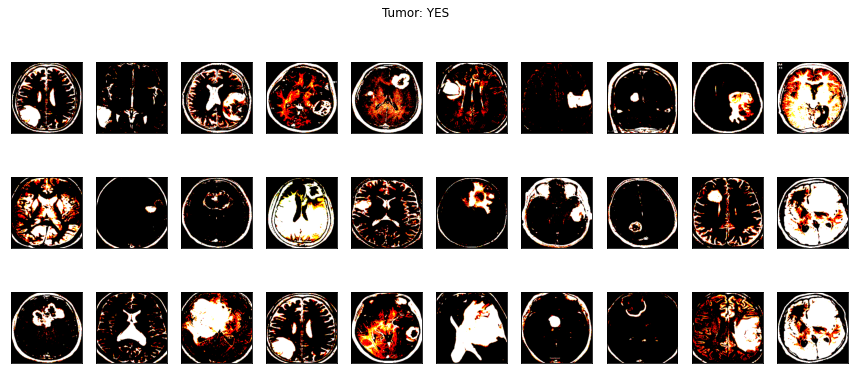

In [21]:
plot_samples(X_train_prep, y_train, labels, 30)

In [22]:
# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)


In [23]:
os.mkdir('preview')
x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 


FileExistsError: ignored

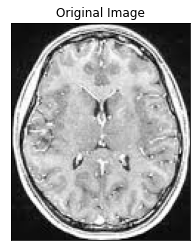

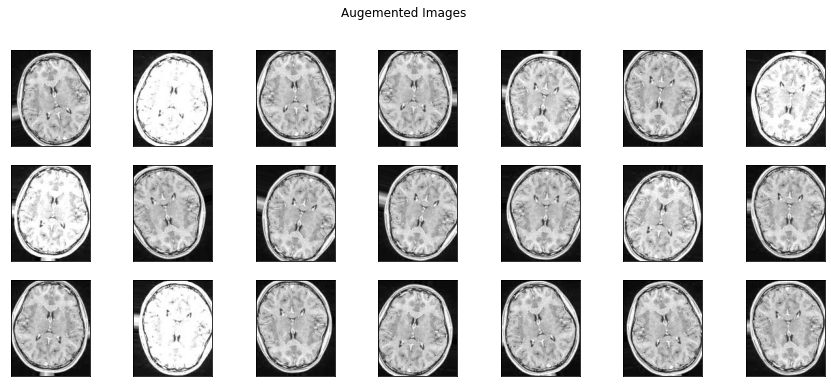

In [24]:
import cv2
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()


In [32]:
y
!pip uninstall opencv-python

Found existing installation: opencv-python 4.6.0.66
Uninstalling opencv-python-4.6.0.66:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/cv2/*
    /usr/local/lib/python3.8/dist-packages/opencv_python-4.6.0.66.dist-info/*
    /usr/local/lib/python3.8/dist-packages/opencv_python.libs/libQt5Core-39545cc7.so.5.15.0
    /usr/local/lib/python3.8/dist-packages/opencv_python.libs/libQt5Gui-48e93776.so.5.15.0
    /usr/local/lib/python3.8/dist-packages/opencv_python.libs/libQt5Test-c38a5234.so.5.15.0
    /usr/local/lib/python3.8/dist-packages/opencv_python.libs/libQt5Widgets-e69d94fb.so.5.15.0
    /usr/local/lib/python3.8/dist-packages/opencv_python.libs/libQt5XcbQpa-c112ba75.so.5.15.0
    /usr/local/lib/python3.8/dist-packages/opencv_python.libs/libX11-xcb-69166bdf.so.1.0.0
    /usr/local/lib/python3.8/dist-packages/opencv_python.libs/libXau-00ec42fe.so.6.0.0
    /usr/local/lib/python3.8/dist-packages/opencv_python.libs/libavcodec-5896f664.so.58.134.100
    /usr/local/lib/python3.8/d

In [33]:
pip uninstall opencv-contrib-python


Found existing installation: opencv-contrib-python 4.6.0.66
Uninstalling opencv-contrib-python-4.6.0.66:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/opencv_contrib_python-4.6.0.66.dist-info/*
    /usr/local/lib/python3.8/dist-packages/opencv_contrib_python.libs/libQt5Core-39545cc7.so.5.15.0
    /usr/local/lib/python3.8/dist-packages/opencv_contrib_python.libs/libQt5Gui-48e93776.so.5.15.0
    /usr/local/lib/python3.8/dist-packages/opencv_contrib_python.libs/libQt5Test-c38a5234.so.5.15.0
    /usr/local/lib/python3.8/dist-packages/opencv_contrib_python.libs/libQt5Widgets-e69d94fb.so.5.15.0
    /usr/local/lib/python3.8/dist-packages/opencv_contrib_python.libs/libQt5XcbQpa-c112ba75.so.5.15.0
    /usr/local/lib/python3.8/dist-packages/opencv_contrib_python.libs/libX11-xcb-69166bdf.so.1.0.0
    /usr/local/lib/python3.8/dist-packages/opencv_contrib_python.libs/libXau-00ec42fe.so.6.0.0
    /usr/local/lib/python3.8/dist-packages/opencv_contrib_python.libs/libavcodec-5896f664.so.58

In [34]:
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached opencv_python-4.6.0.66-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (60.9 MB)


In [35]:
pip install opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached opencv_contrib_python-4.6.0.66-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (67.1 MB)


In [25]:
!rm -rf preview/



In [26]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)



Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [28]:
# load base model
vgg16_weight_path = '/content/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(
    weights=vgg16_weight_path,
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)


     

In [29]:
NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [30]:
EPOCHS = 30
es = EarlyStopping(
    monitor='val_acc', 
    mode='max',
    patience=6
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)


<ipython-input-30-d1be9b42235d>:8: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/30
 7/50 [===>..........................] - ETA: 10:11 - loss: 5.8486 - accuracy: 0.5337

50/50 [==============================] - 132s 2s/step - loss: 5.8486 - accuracy: 0.5337 - val_loss: 2.8378 - val_accuracy: 0.6600


In [34]:
import tensorflow as tf
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5", save_best_only=True, verbose = 0)
]





model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate= 0.0001), metrics=['accuracy'])


history = model.fit(train_generator, validation_data = validation_generator, epochs = 100, 
                    callbacks = [callbacks], verbose = 1)

Epoch 1/100
7/7 [==============================] - 136s 22s/step - loss: 4.8055 - accuracy: 0.5803 - val_loss: 2.2894 - val_accuracy: 0.6800
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 5.8260 - accuracy: 0.4922 

KeyboardInterrupt: ignored

In [35]:
import tensorflow as tf
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5", save_best_only=True, verbose = 0)
]





model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate= 0.0001), metrics=['accuracy'])


history = model.fit(train_generator, validation_data = validation_generator, epochs = 30, 
                    callbacks = [callbacks], verbose = 1)

Epoch 1/30
7/7 [==============================] - 134s 19s/step - loss: 4.6899 - accuracy: 0.5907 - val_loss: 2.3619 - val_accuracy: 0.7000
Epoch 2/30
7/7 [==============================] - 128s 18s/step - loss: 3.5579 - accuracy: 0.6321 - val_loss: 1.5825 - val_accuracy: 0.7800
Epoch 3/30
7/7 [==============================] - 130s 19s/step - loss: 3.5702 - accuracy: 0.6321 - val_loss: 2.4688 - val_accuracy: 0.7000
Epoch 4/30
7/7 [==============================] - 128s 18s/step - loss: 3.5218 - accuracy: 0.6373 - val_loss: 2.4326 - val_accuracy: 0.7400
Epoch 5/30
7/7 [==============================] - 128s 18s/step - loss: 3.3689 - accuracy: 0.6580 - val_loss: 2.0217 - val_accuracy: 0.7600
Epoch 6/30
7/7 [==============================] - 131s 18s/step - loss: 3.6861 - accuracy: 0.6580 - val_loss: 1.2317 - val_accuracy: 0.8000
Epoch 7/30
7/7 [==============================] - 128s 18s/step - loss: 4.0433 - accuracy: 0.6373 - val_loss: 1.1103 - val_accuracy: 0.8000
Epoch 8/30
7/7 [====

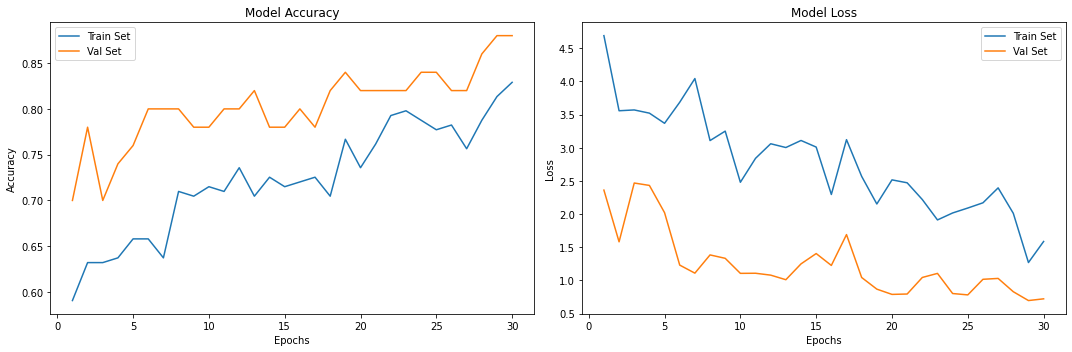

In [45]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

2/2 [==============================] - 8s 2s/step
Val Accuracy = 0.64


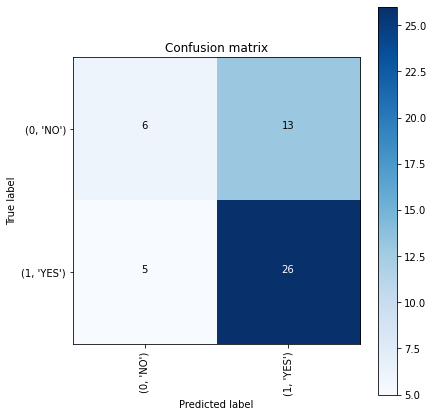

In [52]:
# validate on val set
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)


1/1 [==============================] - 1s 1s/step
Test Accuracy = 0.90


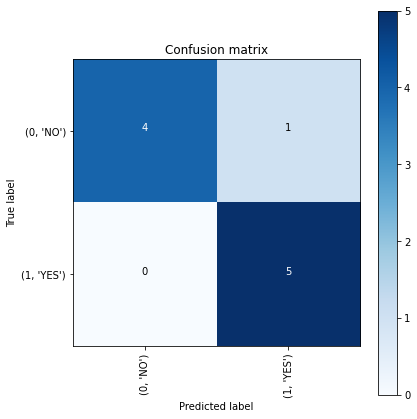

In [53]:

# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)


In [48]:
#RESNET
from tensorflow import keras
base_model = keras.applications.ResNet50V2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))


# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()


94668760/94668760 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 2,049
Non-trainable

In [49]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5", save_best_only=True, verbose = 0)
]

In [50]:

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate= 0.0001), metrics=['accuracy'])

history_res = model.fit(train_generator, validation_data = validation_generator, epochs = 100, 
                    callbacks = [callbacks], verbose = 1)

Epoch 1/100
7/7 [==============================] - 42s 5s/step - loss: 182.4858 - accuracy: 0.6321 - val_loss: 132.7716 - val_accuracy: 0.6200
Epoch 2/100
7/7 [==============================] - 38s 5s/step - loss: 130.1640 - accuracy: 0.6218 - val_loss: 93.7304 - val_accuracy: 0.6200
Epoch 3/100
7/7 [==============================] - 38s 5s/step - loss: 121.3535 - accuracy: 0.5596 - val_loss: 56.7199 - val_accuracy: 0.6200
Epoch 4/100
7/7 [==============================] - 37s 5s/step - loss: 86.3201 - accuracy: 0.5803 - val_loss: 28.0876 - val_accuracy: 0.6000
Epoch 5/100
7/7 [==============================] - 40s 6s/step - loss: 84.3740 - accuracy: 0.5078 - val_loss: 19.3850 - val_accuracy: 0.6000
Epoch 6/100
7/7 [==============================] - 37s 5s/step - loss: 84.4510 - accuracy: 0.5181 - val_loss: 19.2574 - val_accuracy: 0.6200
Epoch 7/100
7/7 [==============================] - 37s 5s/step - loss: 82.0291 - accuracy: 0.5699 - val_loss: 18.3115 - val_accuracy: 0.6000
Epoch 8/1

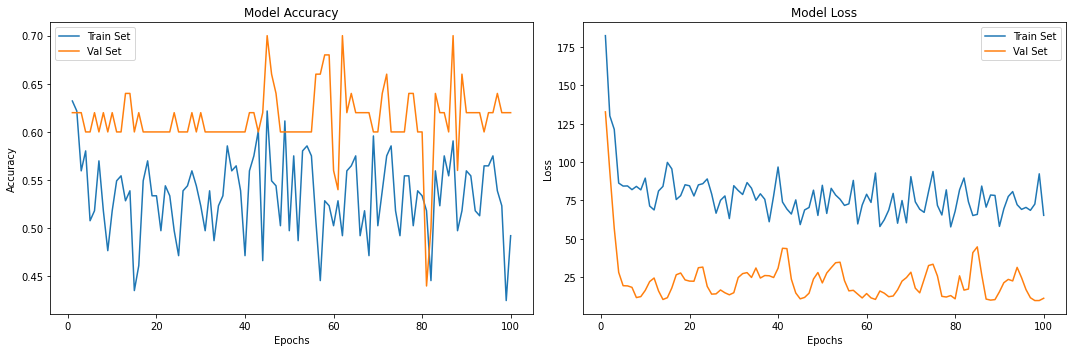

In [51]:
#RESNET ACCURACY PLOT
# plot model performance
acc = history_res.history['accuracy']
val_acc = history_res.history['val_accuracy']
loss = history_res.history['loss']
val_loss = history_res.history['val_loss']
epochs_range = range(1, len(history_res.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

2/2 [==============================] - 7s 2s/step
Val Accuracy = 0.64


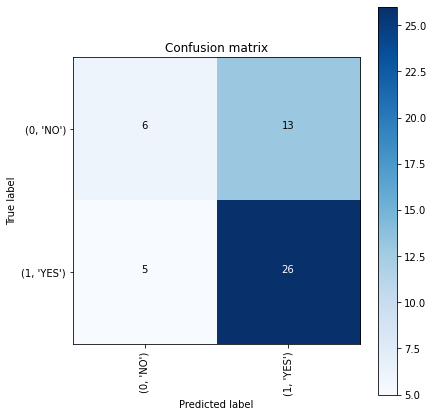

In [54]:
#RESNET VALIDATE ON VALIDATION SET
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)


1/1 [==============================] - 2s 2s/step
Test Accuracy = 0.90


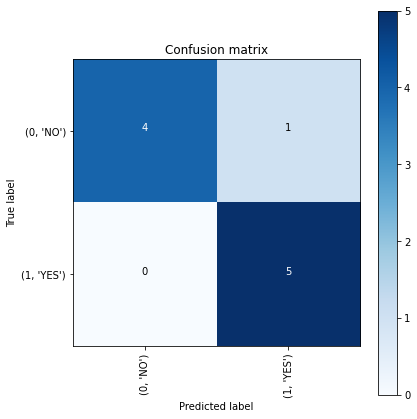

In [55]:
#RESNET TEST SET VALIDATION

# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)
